In [1]:
import os
import matplotlib.pyplot as plt   # plots
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import h5py
import warnings

from libra_py import units

In [2]:
def exp_func(t, e0, tau):
    beta = 1.0
    return e0 * np.exp(-np.power(t / tau, beta))

<Figure size 864x1296 with 0 Axes>

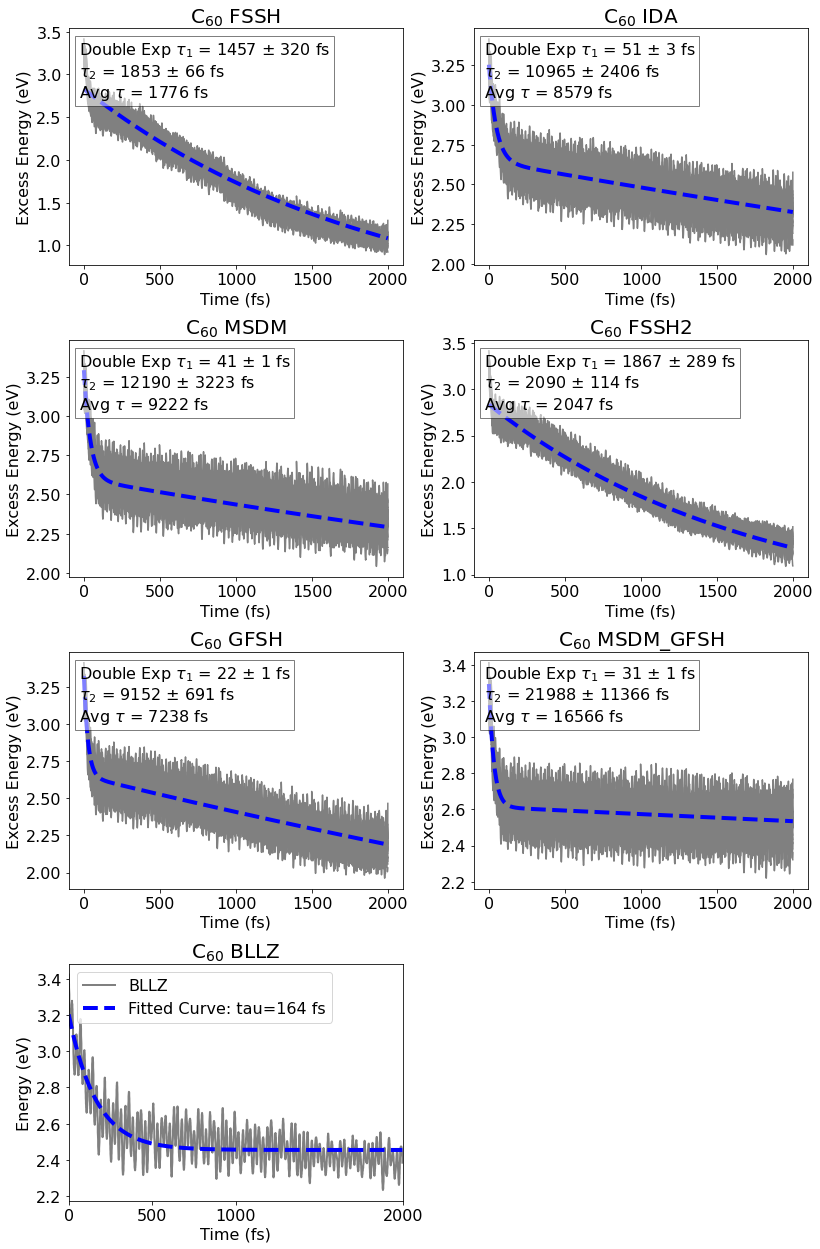

In [5]:
%matplotlib inline
import numpy as np
import scipy.sparse as sp
import h5py
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
from libra_py import units
from libra_py.workflows.nbra import lz, step4
from libra_py import data_outs, data_conv

au2ev = physical_constants['hartree-electron volt relationship'][0]
au2fs = physical_constants['atomic unit of time'][0] * 1e15  

def double_exp_func(t, A1, tau1, A2, tau2, c):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + c

plt.figure(figsize=(12, 18))  
energies = []

for step in range(1000, 4994):
    energy = sp.load_npz(f'../ustep3/res-mb-sd-DFT/Hvib_ci_{step}_re.npz').todense().real
    energies.append(np.diag(energy))

energies = np.array(energies)
energies = au2ev * energies
e2 = energies

methods = ['FSSH', 'IDA', 'MSDM', 'FSSH2', 'GFSH', 'MSDM_GFSH']

fig, axs = plt.subplots(4, 2, figsize=(12, 18))  
for c, method in enumerate(methods):
    row, col = divmod(c, 2)
    ax = axs[row, col]
    taus_double_exp = []
    averaged_times = []

    for icond in range(1, 3994, 200):
        F = h5py.File(f'{method}_latestnewNBRA_icond_{icond}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'])
        time = np.array(F['time/data'])[0:3994] * au2fs 

        tmp2 = np.roll(e2[0:3994, :], -icond, axis=0)
        tmp1 = np.multiply(sh_pop[0:3994, :], tmp2)
        tmp = np.sum(tmp1, axis=1)
        ax.plot(time, tmp, color='gray')  

        initial_energy = tmp[0]
        initial_guess = [initial_energy / 3, 100, initial_energy / 3, 1000, initial_energy / 3]

        lower_bounds = [0, 0, 0, 0, 0]
        upper_bounds = [initial_energy, np.inf, initial_energy, np.inf, initial_energy]

        popt_double_exp, _ = curve_fit(double_exp_func, time, tmp, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
        A1_double_exp, tau1_double_exp, A2_double_exp, tau2_double_exp, c_double_exp = popt_double_exp
        taus_double_exp.append((tau1_double_exp, tau2_double_exp))

        if A1_double_exp + A2_double_exp > 0: 
            avg_tau = (A1_double_exp * tau1_double_exp + A2_double_exp * tau2_double_exp) / (A1_double_exp + A2_double_exp)
        else:
            avg_tau = np.nan 

        averaged_times.append(avg_tau)

    taus_double_exp = np.array(taus_double_exp)
    ave_tau_double_exp = np.average(taus_double_exp, axis=0)
    std_tau_double_exp = np.std(taus_double_exp, axis=0)
    N_double_exp = len(taus_double_exp)
    Z = 1.96
    tau_error_double_exp = Z * std_tau_double_exp / np.sqrt(N_double_exp)
    ave_tau_double_exp_ps = ave_tau_double_exp 
    tau_error_double_exp_ps = tau_error_double_exp 

    time_fit = np.linspace(time[0], time[-1], 1000)
    fit_line = double_exp_func(time_fit, A1_double_exp, tau1_double_exp, A2_double_exp, tau2_double_exp, c_double_exp)
    ax.plot(time_fit, fit_line, 'b--', label='Double Exp Fit', linewidth=4)

    tau_text = (
        f'Double Exp $\\tau_1$ = {int(ave_tau_double_exp_ps[0])} $\\pm$ {int(tau_error_double_exp_ps[0])} fs\n'
        f'$\\tau_2$ = {int(ave_tau_double_exp_ps[1])} $\\pm$ {int(tau_error_double_exp_ps[1])} fs\n'
        f'Avg $\\tau$ = {int(np.nanmean(averaged_times))} fs'
    )
    ax.text(0.03, 0.95, tau_text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    ax.set_title(f'C$_{{60}}$ {method}', fontsize=20)
    ax.set_xlabel('Time (fs)', fontsize=16)
    ax.set_ylabel('Excess Energy (eV)', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0, 500, 1000, 1500, 2000]) 

bllz_ax = axs[3, 0]

params = { "data_set_paths": ["/projects/academic/alexeyak/kosar/cp2k/fullerenes/c60-MOs60/ustep3/res-mb-sd-DFT/"], 
           "Hvib_re_prefix": "Hvib_ci_", "Hvib_re_suffix" : "_re", 
           "Hvib_im_prefix": "Hvib_ci_", "Hvib_im_suffix" : "_im",
           "init_times":1000,  "nfiles":3994, 
           "nstates":75,"active_space": list(range(75) )
         }

Hvibs = step4.get_Hvib_scipy(params)

params = { "dt":0.5*units.fs2au, "ntraj":1, "nsteps":3994, "istate":54, 
           "Boltz_opt_BL":1, "Boltz_opt":1, "T":300.0,  
           "do_output":True, "outfile":"BL.txt", "do_return":True, 
           "evolve_Markov":True, "evolve_TSH":False, 
           "extend_md":False, "extend_md_time":3994,
           "detect_SD_difference":False,   "return_probabilities":False,
           "init_times":[0]           
         }
params["gap_min_exception"] = 0 
params["target_space"] = 0 

res, _ = lz.run(Hvibs, params)
res0 = data_conv.MATRIX2nparray(res, _dtype=float)

def E_function(t, E0, Einf, tau):
    return (E0 - Einf) * np.exp(-t / tau) + Einf

t_bdata = res0[:, 0] * units.au2fs
E_SE_bdata = res0[:, 229] * units.au2ev


t_bdata_rounded = np.round(t_bdata)

p0 = (E_SE_bdata[0], E_SE_bdata[-1], 100.0) 
popt, pcov = curve_fit(E_function, t_bdata, E_SE_bdata, p0=p0)
E0_fit, Einf_fit, tau_fit = popt  

# Plot BLLZ
bllz_ax.plot(t_bdata_rounded, E_SE_bdata, color="gray", label="BLLZ", linewidth=2)
bllz_ax.plot(t_bdata_rounded, E_function(t_bdata_rounded, *popt), color="blue", linestyle="--",
             label="Fitted Curve: tau={:.0f} fs".format(tau_fit), linewidth=4)

bllz_ax.set_xlabel('Time (fs)', fontsize=16)
bllz_ax.set_ylabel('Energy (eV)', fontsize=16)
bllz_ax.set_title('C$_{60}$ BLLZ', fontsize=20)
bllz_ax.tick_params(axis='both', which='major', labelsize=16)
bllz_ax.legend(loc='upper left', fontsize=16) 

fig.delaxes(axs[3, 1]) 

bllz_ax.set_xlim(0, 2000)
bllz_ax.set_xticks([0, 500, 1000, 2000])  

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout(rect=[0.05, 0, 1, 0.97])
plt.savefig('C60.png', dpi=600, bbox_inches='tight')
plt.show()


<Figure size 591.12x461.52 with 0 Axes>

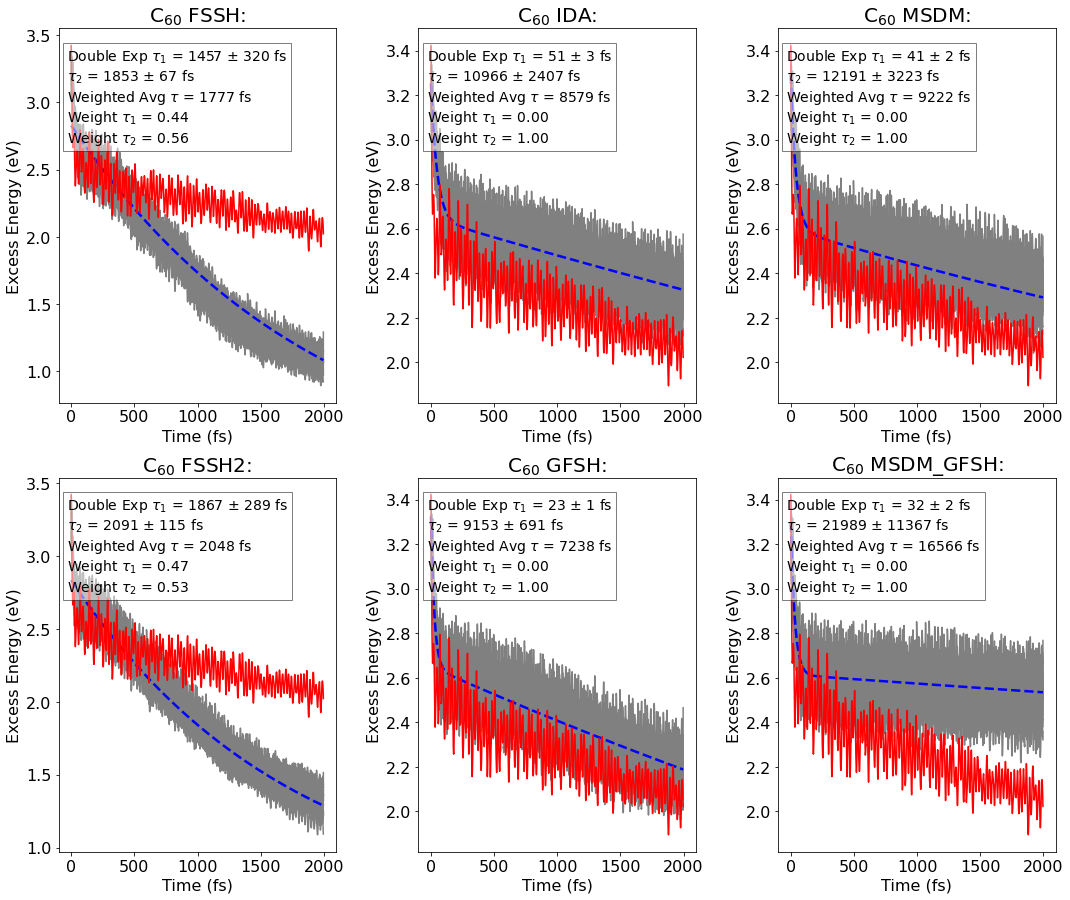

In [23]:
import numpy as np
import scipy.sparse as sp
import h5py
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
from libra_py import units
from libra_py.workflows.nbra import lz, step4
from libra_py import data_outs, data_conv

au2ev = physical_constants['hartree-electron volt relationship'][0]
au2fs = physical_constants['atomic unit of time'][0] * 1e15  

# Double exponential function 
def double_exp_func(t, A1, tau1, A2, tau2, c):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + c

# Single exponential function for BLLZ fitting
def E_function(t, E0, Einf, tau):
    return (E0 - Einf) * np.exp(-t / tau) + Einf

# BLLZ
params = {
    "data_set_paths": ["/projects/academic/alexeyak/kosar/cp2k/fullerenes/c60-MOs60/ustep3/res-mb-sd-DFT/"],
    "Hvib_re_prefix": "Hvib_ci_", "Hvib_re_suffix": "_re",
    "Hvib_im_prefix": "Hvib_ci_", "Hvib_im_suffix": "_im",
    "init_times": 1000, "nfiles": 3994,
    "nstates": 75, "active_space": list(range(75))
}

# Get Hvib data
Hvibs = step4.get_Hvib_scipy(params)

params_lz = {
    "dt": 0.5 * units.fs2au, "ntraj": 1, "nsteps": 3994, "istate": 54,
    "Boltz_opt_BL": 1, "Boltz_opt": 1, "T": 300.0,
    "do_output": True, "outfile": "BL.txt", "do_return": True,
    "evolve_Markov": True, "evolve_TSH": False,
    "extend_md": False, "extend_md_time": 3994,
    "detect_SD_difference": False, "return_probabilities": False,
    "init_times": [0]
}

# BLLZ
res, _ = lz.run(Hvibs, params_lz)
res0 = data_conv.MATRIX2nparray(res, _dtype=float)
t_data = res0[:, 0] * units.au2fs
E_SE_data = res0[:, 229] * units.au2ev

plt.figure(figsize=(8.21, 6.41))
energies = []

for step in range(1000, 4994):
    energy = sp.load_npz(f'../ustep3/res-mb-sd-DFT/Hvib_ci_{step}_re.npz').todense().real
    energies.append(np.diag(energy))

energies = np.array(energies)
energies = au2ev * energies
e2 = energies

methods = [
    'FSSH', 'IDA', 'MSDM',
    'FSSH2', 'GFSH', 'MSDM_GFSH',
]

fig, axs = plt.subplots(2, 3, figsize=(15, 13))  # Adjusted figure size

for c, method in enumerate(methods):
    row, col = divmod(c, 3)
    ax = axs[row, col]
    taus_double_exp = []
    averaged_times = []
    
    for icond in range(1, 3994, 200):
        F = h5py.File(f'{method}_latestnewNBRA_icond_{icond}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'])
        time = np.array(F['time/data'])[0:3994] * au2fs  # Converted to femtoseconds

        tmp2 = np.roll(e2[0:3994, :], -icond, axis=0)
        tmp1 = np.multiply(sh_pop[0:3994, :], tmp2)
        tmp = np.sum(tmp1, axis=1)
        ax.plot(time, tmp, color='gray')

        # Initial guess for the parameters
        initial_energy = tmp[0]
        initial_guess = [initial_energy / 3, 100, initial_energy / 3, 1000, initial_energy / 3]
        
        # Bounds to ensure positivity and the sum constraint
        lower_bounds = [0, 0, 0, 0, 0]
        upper_bounds = [initial_energy, np.inf, initial_energy, np.inf, initial_energy]
        
        # Double exponential fit
        popt_double_exp, _ = curve_fit(double_exp_func, time, tmp, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
        A1_double_exp, tau1_double_exp, A2_double_exp, tau2_double_exp, c_double_exp = popt_double_exp
        taus_double_exp.append((tau1_double_exp, tau2_double_exp))

        # Calculate the weighted average of tau
        if A1_double_exp + A2_double_exp > 0:  # Ensure no division by zero
            weight_tau1 = A1_double_exp / (A1_double_exp + A2_double_exp)
            weight_tau2 = A2_double_exp / (A1_double_exp + A2_double_exp)
            avg_tau = weight_tau1 * tau1_double_exp + weight_tau2 * tau2_double_exp
        else:
            avg_tau = np.nan  # Assign NaN if the weights are zero

        averaged_times.append(avg_tau)

    # Average for double exponential fit
    taus_double_exp = np.array(taus_double_exp)
    ave_tau_double_exp = np.average(taus_double_exp, axis=0)
    std_tau_double_exp = np.std(taus_double_exp, axis=0)
    N_double_exp = len(taus_double_exp)
    Z = 1.96
    tau_error_double_exp = Z * std_tau_double_exp / np.sqrt(N_double_exp)
    ave_tau_double_exp_ps = ave_tau_double_exp 
    tau_error_double_exp_ps = tau_error_double_exp 
    
    weight_tau1 = ave_tau_double_exp_ps[0] / (ave_tau_double_exp_ps[0] + ave_tau_double_exp_ps[1])
    weight_tau2 = ave_tau_double_exp_ps[1] / (ave_tau_double_exp_ps[0] + ave_tau_double_exp_ps[1])

    # Plot average double exponential fit line
    time_fit = np.linspace(time[0], time[-1], 1000)
    fit_line = double_exp_func(time_fit, A1_double_exp, tau1_double_exp, A2_double_exp, tau2_double_exp, c_double_exp)
    ax.plot(time_fit, fit_line, 'b--', label='Double Exp Fit', linewidth=2.5)

    # Add tau values, averaged time, and weights
    tau_text = (
        f'Double Exp $\\tau_1$ = {ave_tau_double_exp_ps[0]:.0f} $\\pm$ {tau_error_double_exp_ps[0]:.0f} fs\n'
        f'$\\tau_2$ = {ave_tau_double_exp_ps[1]:.0f} $\\pm$ {tau_error_double_exp_ps[1]:.0f} fs\n'
        f'Weighted Avg $\\tau$ = {np.nanmean(averaged_times):.0f} fs\n'
        f'Weight $\\tau_1$ = {weight_tau1:.2f}\n'
        f'Weight $\\tau_2$ = {weight_tau2:.2f}'
    )
    ax.text(0.03, 0.95, tau_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Add BLLZ curve to the plot
    ax.plot(t_data, E_SE_data, color="red", label="BLLZ E_SE")
    ax.set_title(f'C$_{{60}}$ {method}:', fontsize=20)
    ax.set_xlabel('Time (fs)', fontsize=16)
    ax.set_ylabel('Excess Energy (eV)', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.legend()

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('c60-BLLZ-TSH.png', dpi=600, bbox_inches='tight')
plt.show()


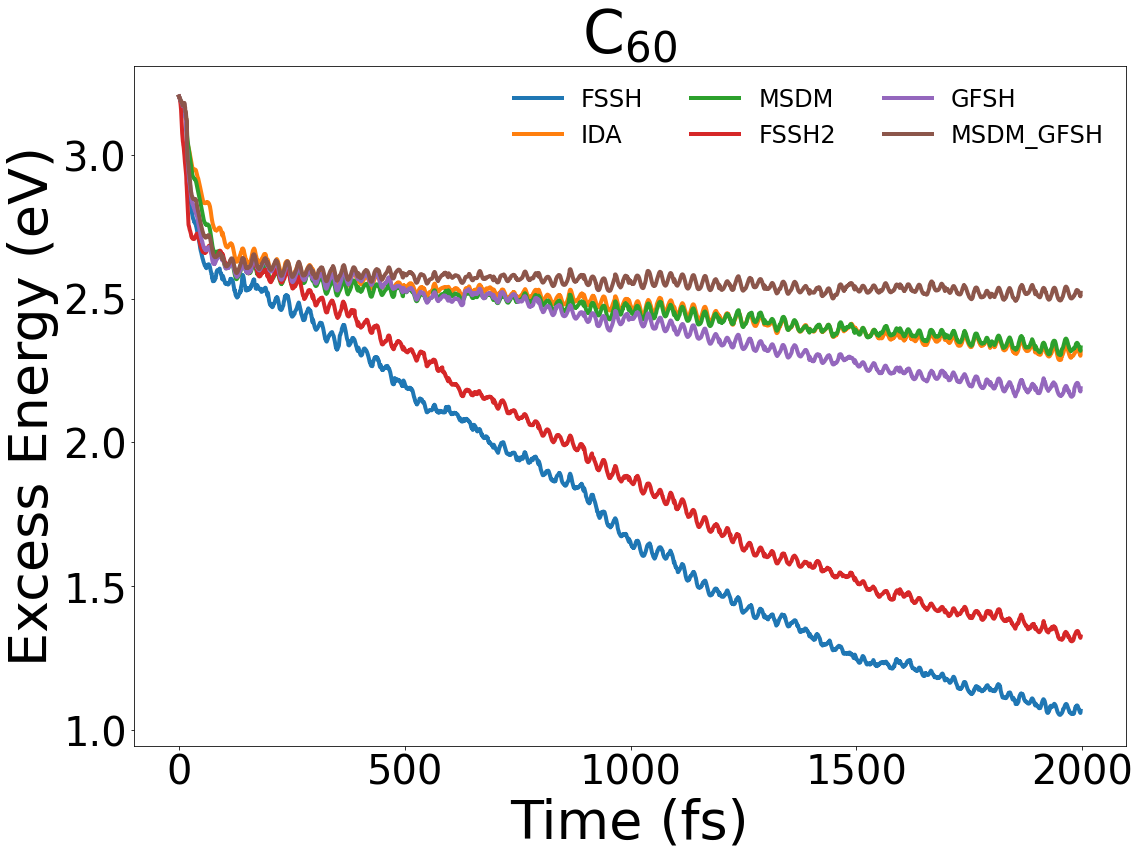

In [17]:
%matplotlib inline
import numpy as np
import scipy.sparse as sp
import h5py
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
from matplotlib.ticker import FormatStrFormatter

au2ev = physical_constants['hartree-electron volt relationship'][0]
au2fs = physical_constants['atomic unit of time'][0] * 1e15  

def exp_func_2(t, A, tau, beta):
    return A * np.exp(-np.power(t / tau, beta))

A = 2.91

energies = []

for step in range(1000, 4994):
    energy = sp.load_npz(f'../ustep3/res-mb-sd-DFT/Hvib_ci_{step}_re.npz').todense().real
    energies.append(np.diag(energy))

energies = np.array(energies)
energies = au2ev * energies
e2 = energies
methods =['FSSH','IDA', 'MSDM', 'FSSH2', 'GFSH', 'MSDM_GFSH']

fig, ax = plt.subplots(figsize=(16, 12))  # Larger figure size for the combined plot

for method in methods:
    all_excess_energies = []
    taus = []

    for icond in range(1, 3994, 200):
        F = h5py.File(f'{method}_latestnewNBRA_icond_{icond}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'])
        time = np.array(F['time/data'])[0:3994] * au2fs 
        a = sh_pop.shape[1]

        tmp2 = np.roll(e2[0:3994, :], -icond, axis=0)
        tmp1 = np.multiply(sh_pop[0:3994, :], tmp2)
        tmp = np.sum(tmp1, axis=1)
        all_excess_energies.append(tmp)

        popt, pcov = curve_fit(exp_func_2, time, tmp, bounds=([A - 0.000001, 0.0, 0.5], [A + 0.000001, np.inf, 4.0]))
        A_fit, tau_fit, beta_fit = popt
        taus.append(tau_fit)

    # Average excess energy
    avg_excess_energy = np.mean(all_excess_energies, axis=0)
    
    taus = np.array(taus)
    ave_tau = np.average(taus)
    std_tau = np.std(taus)
    N = len(taus)
    Z = 1.96
    tau_error = Z * std_tau / np.sqrt(N)
    
    ave_tau_ps = ave_tau / 1000
    tau_error_ps = tau_error / 1000

    label_with_tau = f'{method}'
    
    ax.plot(time, avg_excess_energy, label=label_with_tau, linewidth=4)

ax.set_title('C$_{{60}}$', fontsize=60)
ax.set_xlabel('Time (fs)', fontsize=54)
ax.set_ylabel('Excess Energy (eV)', fontsize=54)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.legend(fontsize=24, loc='upper right', 
        ncol=3,
        frameon=False  
    )
plt.tight_layout()

plt.savefig('c60-ExcessEnergy.png', dpi=600, bbox_inches='tight')
plt.show()

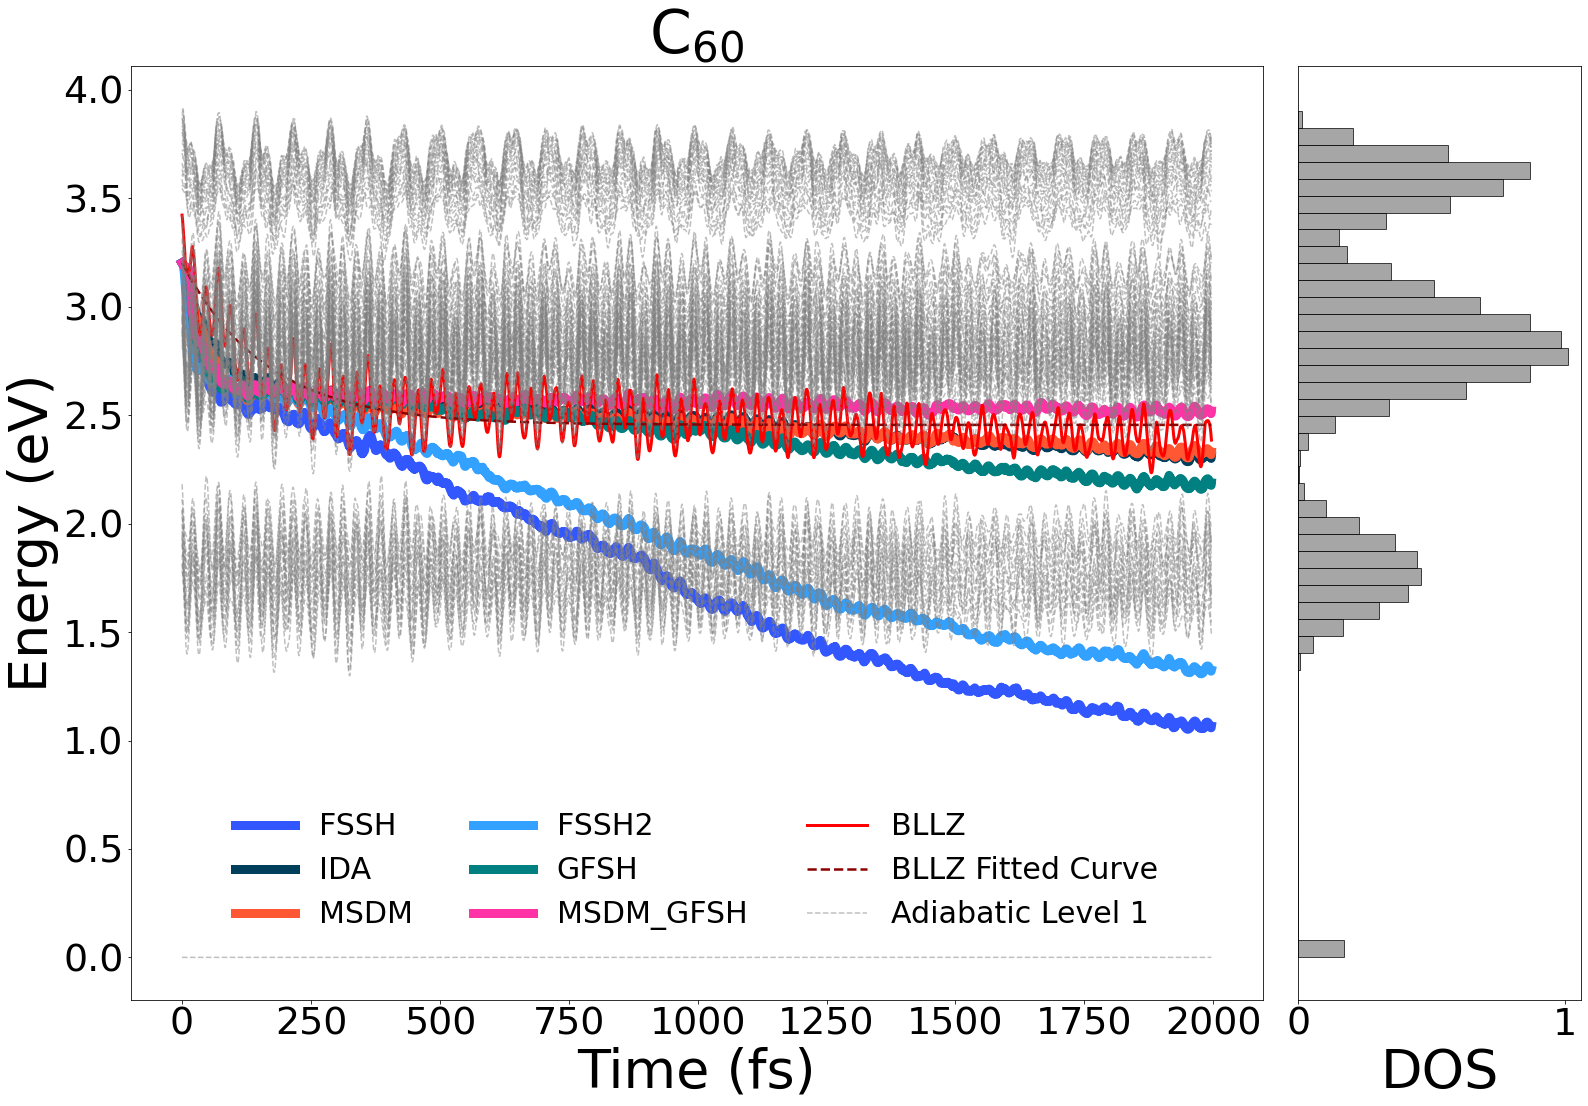

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import h5py
from scipy.optimize import curve_fit

bright_colors =[
    '#3357ff', '#003f5c', '#FF5733','#33A1FF', '#008080', '#FF33A6', 
]

plt.figure(figsize=(26, 22))
gs = plt.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.05, hspace=0.05)

ax0 = plt.subplot(gs[1, 0])
ax1 = plt.subplot(gs[1, 1], sharey=ax0)

adiabatic_energies = []
time = None

for step in range(1000, 4994):
    energy = sp.load_npz(f'../ustep3/res-mb-sd-DFT/Hvib_ci_{step}_re.npz').todense().real
    if time is None:
        time = np.arange(energy.shape[0]) * au2fs
    adiabatic_energies.append(np.diag(energy))

adiabatic_energies = np.array(adiabatic_energies)
adiabatic_energies = au2ev * adiabatic_energies


for method, color in zip(methods, bright_colors):
    all_excess_energies = []
    taus = []

    for icond in range(1, 3994, 200):
        F = h5py.File(f'{method}_latestnewNBRA_icond_{icond}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'])
        time = np.array(F['time/data'])[0:3994] * au2fs  # Converted to femtoseconds

        tmp2 = np.roll(e2[0:3994, :], -icond, axis=0)
        tmp1 = np.multiply(sh_pop[0:3994, :], tmp2)
        tmp = np.sum(tmp1, axis=1)
        all_excess_energies.append(tmp)

        try:
            popt, _ = curve_fit(exp_func_2, time, tmp, bounds=([2.91 - 0.000001, 0.0, 0.5], [2.91 + 0.000001, np.inf, 4.0]))
            _, tau_fit, _ = popt
            taus.append(tau_fit)
        except Exception as e:
            print(f"Error fitting data for method {method}: {e}")

    avg_excess_energy = np.mean(all_excess_energies, axis=0)

    if taus: 
        taus = np.array(taus)
        ave_tau = np.average(taus)
        std_tau = np.std(taus)
        N = len(taus)
        Z = 1.96
        tau_error = Z * std_tau / np.sqrt(N)

        ave_tau_ps = ave_tau 
        tau_error_ps = tau_error 

        label_with_tau = f'{method}'
        
        ax0.plot(time, avg_excess_energy, label=label_with_tau, color=color, linewidth=9) 

params = {
    "data_set_paths": ["/projects/academic/alexeyak/kosar/cp2k/fullerenes/c60-MOs60/ustep3/res-mb-sd-DFT/"], 
    "Hvib_re_prefix": "Hvib_ci_", "Hvib_re_suffix": "_re", 
    "Hvib_im_prefix": "Hvib_ci_", "Hvib_im_suffix": "_im",
    "init_times":1000, "nfiles":3994, 
    "nstates":75, "active_space": list(range(75))
}

Hvibs = step4.get_Hvib_scipy(params)
params = {
    "dt": 0.5 * units.fs2au, "ntraj": 1, "nsteps": 3994, "istate": 54,  # Changed to 2000 steps
    "Boltz_opt_BL": 1, "Boltz_opt": 1, "T": 300.0,  
    "do_output": True, "outfile": "BL.txt", "do_return": True, 
    "evolve_Markov": True, "evolve_TSH": False, 
    "extend_md": False, "extend_md_time": 3994,
    "detect_SD_difference": False, "return_probabilities": False,
    "init_times": [0]           
}
params["gap_min_exception"] = 0
params["target_space"] = 0

res, _ = lz.run(Hvibs, params)
res0 = data_conv.MATRIX2nparray(res, _dtype=float)

t_data = res0[:, 0] * units.au2fs
E_SE_data = res0[:, 229] * units.au2ev

p0 = (E_SE_data[0], E_SE_data[-1], 100.0)
popt, _ = curve_fit(E_function, t_data, E_SE_data, p0=p0)
E0_fit, Einf_fit, tau_fit = popt

time_fit = np.linspace(t_data.min(), t_data.max(), 500)
energy_fit = E_function(time_fit, *popt)

# Plot energy data and fitted curve
ax0.plot(t_data, E_SE_data, color="red", label="BLLZ", linewidth=3)
ax0.plot(time_fit, energy_fit, color="darkred", linestyle="--", label="BLLZ Fitted Curve", linewidth=2.5)

# Plot Adiabatic Energy Levels
for i in range(adiabatic_energies.shape[1]):
    ax0.plot(time, adiabatic_energies[:, i], linestyle='--', color='gray', alpha=0.5, label=f'Adiabatic Level {i+1}' if i == 0 else "", linewidth=1.5)

# Density of States
energy_levels = []
for i in range(75):
    energy_levels.extend(res0[:, 3 * i + 1] * units.au2ev)
energy_levels = np.array(energy_levels)

ax1.hist(energy_levels, bins=50, density=True, orientation='horizontal', alpha=0.7, color='gray', edgecolor='black')
ax1.set_xlabel('DOS', fontsize=54)
ax1.tick_params(axis='x', labelsize=38)
ax1.yaxis.set_visible(False)

# Labels
ax0.set_title('C$_{60}$', fontsize=60)
ax0.set_xlabel('Time (fs)', fontsize=54)
ax0.set_ylabel('Energy (eV)', fontsize=54)
ax0.tick_params(axis='both', which='major', labelsize=38)

if ax0.get_legend_handles_labels()[1]:
    ax0.legend(fontsize=30, loc='upper center',
               bbox_to_anchor=(0.5, 0.23), 
               ncol=3,
               frameon=False)
    
plt.savefig('C60-DOS.png', dpi=600)
plt.show()


[1.70804403e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.69774477e-04 5.98713482e-03 5.50388751e-02 1.67169357e-01
 3.02649665e-01 4.10546388e-01 4.58357936e-01 4.46811318e-01
 3.62521013e-01 2.29178968e-01 1.02123414e-01 1.96292492e-02
 2.35208868e-03 5.68777808e-03 3.60083394e-02 1.38516641e-01
 3.41010093e-01 6.28221504e-01 8.69759628e-01 1.01075665e+00
 9.85311330e-01 8.70486637e-01 6.82961022e-01 5.08820929e-01
 3.49263786e-01 1.82650377e-01 1.50875797e-01 3.28608171e-01
 5.69590348e-01 7.68448754e-01 8.68989854e-01 5.62491316e-01
 2.03733645e-01 1.41980626e-02]
1.0107566532003651
[1.16157 1.16229 1.16301 ... 3.30502 3.30574 3.30646]
[3.99888701e-12 4.46686459e-12 4.98862586e-12 ... 1.95970755e-12
 1.75449527e-12 1.57046464e-12]


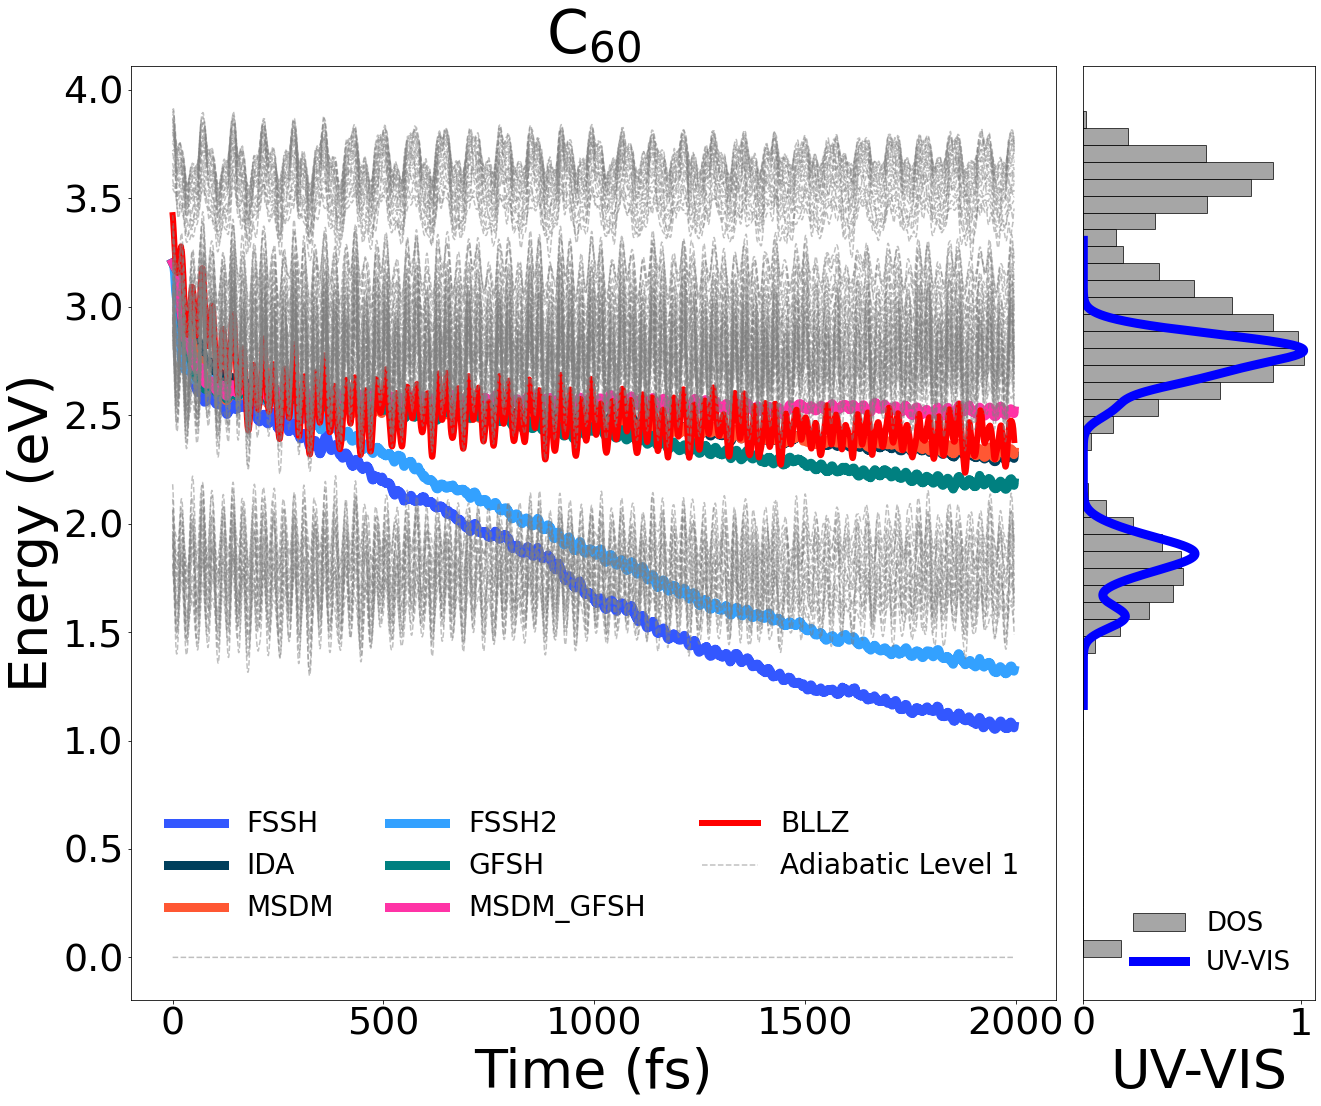

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import h5py
from scipy.optimize import curve_fit

bright_colors = [
    '#3357ff', '#003f5c', '#FF5733','#33A1FF', '#008080', '#FF33A6', 
]
# excess energy data
plt.figure(figsize=(30, 22))
gs = plt.GridSpec(2, 3, width_ratios=[4, 1, 2], height_ratios=[1, 4], wspace=0.05, hspace=0.05)

ax0 = plt.subplot(gs[1, 0])
ax1 = plt.subplot(gs[1, 1], sharey=ax0)

# Adiabatic energy levels for plotting
adiabatic_energies = []
time = None

for step in range(1000, 4994):
    energy = sp.load_npz(f'../ustep3/res-mb-sd-DFT/Hvib_ci_{step}_re.npz').todense().real
    if time is None:
        time = np.arange(energy.shape[0]) * au2fs
    adiabatic_energies.append(np.diag(energy))

adiabatic_energies = np.array(adiabatic_energies)
adiabatic_energies = au2ev * adiabatic_energies

# Plot each method
for method, color in zip(methods, bright_colors):
    all_excess_energies = []
    taus = []

    for icond in range(1, 3994, 200):
        F = h5py.File(f'{method}_latestnewNBRA_icond_{icond}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'])
        time = np.array(F['time/data'])[0:3994] * au2fs  

        tmp2 = np.roll(e2[0:3994, :], -icond, axis=0)
        tmp1 = np.multiply(sh_pop[0:3994, :], tmp2)
        tmp = np.sum(tmp1, axis=1)
        all_excess_energies.append(tmp)

        # Fit the data to get tau
        try:
            popt, _ = curve_fit(exp_func_2, time, tmp, bounds=([2.91 - 0.000001, 0.0, 0.5], [2.91 + 0.000001, np.inf, 4.0]))
            _, tau_fit, _ = popt
            taus.append(tau_fit)
        except Exception as e:
            print(f"Error fitting data for method {method}: {e}")

    avg_excess_energy = np.mean(all_excess_energies, axis=0)

    if taus:  
        taus = np.array(taus)
        ave_tau = np.average(taus)
        std_tau = np.std(taus)
        N = len(taus)
        Z = 1.96
        tau_error = Z * std_tau / np.sqrt(N)

        ave_tau_ps = ave_tau 
        tau_error_ps = tau_error 

        label_with_tau = f'{method}'
        
        ax0.plot(time, avg_excess_energy, label=label_with_tau, color=color, linewidth=9)

# energy data
params = {
    "data_set_paths": ["/projects/academic/alexeyak/kosar/cp2k/fullerenes/c60-MOs60/ustep3/res-mb-sd-DFT/"], 
    "Hvib_re_prefix": "Hvib_ci_", "Hvib_re_suffix": "_re", 
    "Hvib_im_prefix": "Hvib_ci_", "Hvib_im_suffix": "_im",
    "init_times":1000, "nfiles":3994, 
    "nstates":75, "active_space": list(range(75))
}

Hvibs = step4.get_Hvib_scipy(params)
params = {
    "dt": 0.5 * units.fs2au, "ntraj": 1, "nsteps": 3994, "istate": 54,  # Changed to 2000 steps
    "Boltz_opt_BL": 1, "Boltz_opt": 1, "T": 300.0,  
    "do_output": True, "outfile": "BL.txt", "do_return": True, 
    "evolve_Markov": True, "evolve_TSH": False, 
    "extend_md": False, "extend_md_time": 3994,
    "detect_SD_difference": False, "return_probabilities": False,
    "init_times": [0]           
}
params["gap_min_exception"] = 0
params["target_space"] = 0

res, _ = lz.run(Hvibs, params)
res0 = data_conv.MATRIX2nparray(res, _dtype=float)

t_data = res0[:, 0] * units.au2fs
E_SE_data = res0[:, 229] * units.au2ev

p0 = (E_SE_data[0], E_SE_data[-1], 100.0)
popt, _ = curve_fit(E_function, t_data, E_SE_data, p0=p0)
E0_fit, Einf_fit, tau_fit = popt

time_fit = np.linspace(t_data.min(), t_data.max(), 500)
energy_fit = E_function(time_fit, *popt)

# Plot energy data and fitted curve
ax0.plot(t_data, E_SE_data, color="red", label="BLLZ", linewidth=6)


# Adiabatic Energy Levels
for i in range(adiabatic_energies.shape[1]):
    ax0.plot(time, adiabatic_energies[:, i], linestyle='--', color='gray', alpha=0.5, label=f'Adiabatic Level {i+1}' if i == 0 else "", linewidth=1.5)

# Density of States
energy_levels = []
for i in range(75):
    energy_levels.extend(res0[:, 3 * i + 1] * units.au2ev)
energy_levels = np.array(energy_levels)


hist_values, bin_edges, patches = ax1.hist(energy_levels, bins=50, density=True, orientation='horizontal', alpha=0.7, color='gray', edgecolor='black', label='DOS')
ax1.set_xlabel('DOS', fontsize=54)
ax1.tick_params(axis='x', labelsize=38)
ax1.yaxis.set_visible(False)

print(hist_values)
max_hist_value = hist_values.max()
print(max_hist_value)

# Normalize spectrum curve
file_path = 'C60-spectrum_curve.txt'

x = []
y = []

with open(file_path, 'r') as file:
    for line in file:
        if line.strip(): 
            parts = line.split()
            xi = float(parts[0])
            yi = float(parts[1])
            x.append(xi)
            y.append(yi)

x = np.array(x)
print(x)
y = np.array(y)
print(y)
max_y = max(y)
y_normalized = (y / max_y) * max_hist_value

ax1.plot(y_normalized, x, linestyle='-', color='b', label='UV-VIS', linewidth=9)
ax1.set_xlabel('UV-VIS', fontsize=54)
ax1.tick_params(axis='x', which='major', labelsize=38) 
ax1.yaxis.set_visible(False) 

ax0.set_title('C$_{60}$', fontsize=60)
ax0.set_xlabel('Time (fs)', fontsize=54)
ax0.set_ylabel('Energy (eV)', fontsize=54)
ax0.tick_params(axis='both', which='major', labelsize=38)


if ax0.get_legend_handles_labels()[1]:
    ax0.legend(fontsize=28, loc='upper center',
               bbox_to_anchor=(0.5, 0.23), 
               ncol=3,
               frameon=False  
    )

handles2, labels2 = ax1.get_legend_handles_labels()
labels += labels2
ax1.legend(handles, labels, fontsize=26, loc='lower right', bbox_to_anchor=(1.0, 0.0), frameon=False)
plt.savefig('C60-DOS+UV.png', dpi=600)
plt.show()